# Garbage Classification Model

This assignment follows the model proposed in assignment 1 to solve the garbage classification problem. The notebook highlights the predictions from the model and the rasoning behind decisions.

The data came pre-split with the assignment instructions.
Number of images in the training folder creates the batch size when training
Initial number of epochs was set arbitrarily


To solve this problem, a custom dataset was created and a MultiModal model was implemented
1. Read data and create numpy arrays of images, text and labels associated.

2. Data pre-processing
- Custom dataset was created. This outputs the images, labels, text, attetion mask and input ids.
The transformation resizes image and applies normalization using statistics based on ResNet training.
- Data Loader was created

3. Model created
- The model uses ResNet50 and BERT as the feature extraction backbone.
- A dense layer is added after each to ensure both input similar number of features. This was normalized and the ReLu activation function added.
- The text and image feature was merged and passed through the final classification layer.
- a log_softmax was used at the end as the output.

![Garbage Classification Model](./Assignment2.png)

4. Training and Validation
- Batch size, learning rate, number of epochs were the main hyperparameters changed
- Early stopping after 5 iterations with no change during training was introduced to the model after noticing  overfitting. The AdamW optimizer with weight decay was used.
- With an imbalanced dataset, a weighted CrossEntropy Loss was used. The class distribution of the training set was:
![Garbage Classification Model](./ClassDistribution.png)

This notebook runs the test section of the code with the best model. Results for testing is given by accuracy, F1 score and the confusion matrix.

## Experimental Setup


In [6]:
# Importing important functions and modules
# Import necessary functions from python files
# Model, Custom dataset and data extraction function
from Data_and_Model import read_text_files_with_labels, CustomDataset, GarbageModel

# Metrics
from Metrics import metrics_eval

#---------- Importing useful packages --------------#
import torch # pytorch main library
import glob
import torchvision # computer vision utilities
import torchvision.transforms as transforms # transforms used in the pre-processing of the data
from torchvision import *

from PIL import Image
from torchvision.models import resnet18, resnet50, ResNet50_Weights
from transformers import DistilBertModel, DistilBertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import time
import copy
import os
import re

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns


# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

##-----------------------------------------------------------------------------------------------------------##

cuda:0


Prediction set: 3431


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


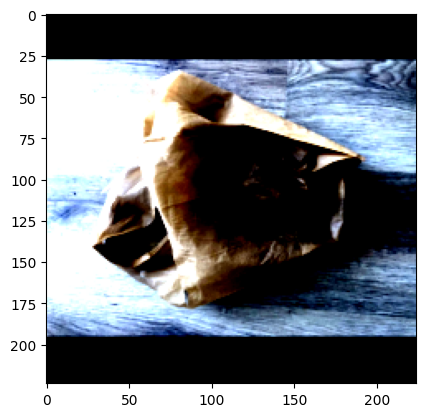

In [7]:
# Set the hyperparameters
batch_size = 256 # Change Batch Size o
num_workers = 2

# Extract data and create Data Loaders
PRED_PATH = r"./CVPR_2024_dataset_Test" # Prediction images path

torchvision_transform_test = transforms.Compose([transforms.Resize((224,224)),\
    transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406] ,std=[0.229, 0.224, 0.225])])

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') # BERT Tokenizer for caption text
max_len = 24

#Dataset has been pre-split, load all data sets.
pred_dataset = CustomDataset(PRED_PATH, max_len, tokenizer, transform=torchvision_transform_test)

# Get the data loader for the train set
predloader = DataLoader(pred_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#Dataset has been pre-split, load all data sets.
pred_set_size = int(len(pred_dataset))

#classes = ('green', 'blue', 'black', 'other')
print("Prediction set:", pred_set_size)

# ##-----------------------------------------------------------------------------------------------------------##
# get some random training images
pred_iterator = iter(predloader)
pred_batch = next(pred_iterator)

# Visualizing a sample image from dataset
plt.figure()
plt.imshow(pred_batch['image'].numpy()[8].transpose(1,2,0)) # Convert tensor to numpy array
plt.show()



# Predictions

F1-SCORE of the netwwork is given ass micro: 0.8426114835324978, macro: 0.8346153475873874
Accuracy of the network on the test images: 84.26114835324978 %


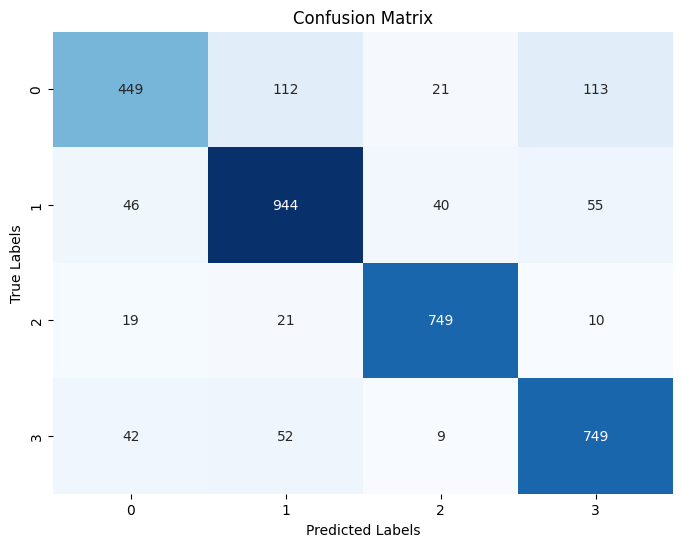

In [8]:
# Loading the best model and predicting classes
PATH = './garbage_net.pth' # Path to save the best model
net = GarbageModel(4, (3,224,224), False)
net.load_state_dict(torch.load(PATH, weights_only=True))

metrics_eval(net, predloader, device) # Plots the confusion matrix too

Plotting the Misclassified samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


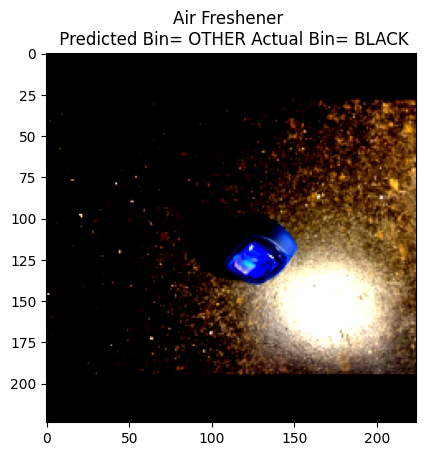

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


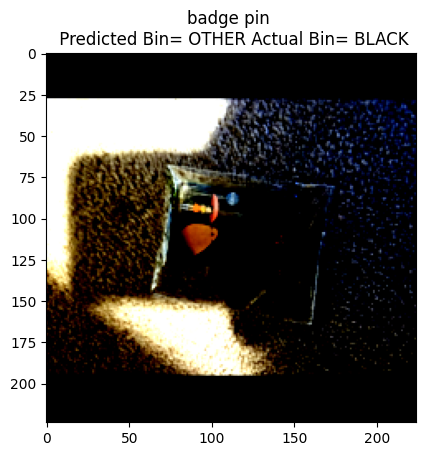

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


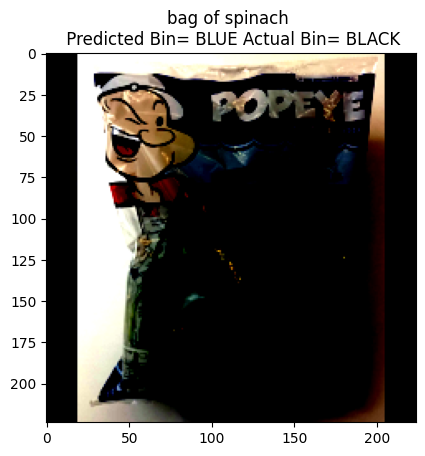

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


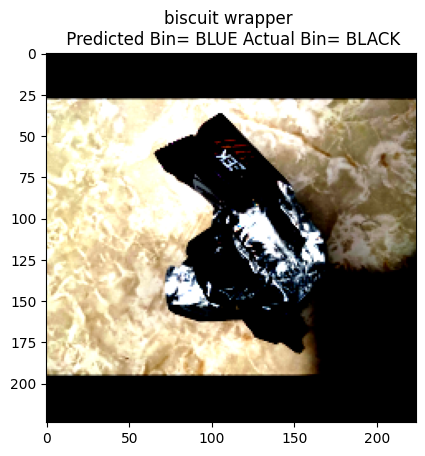

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


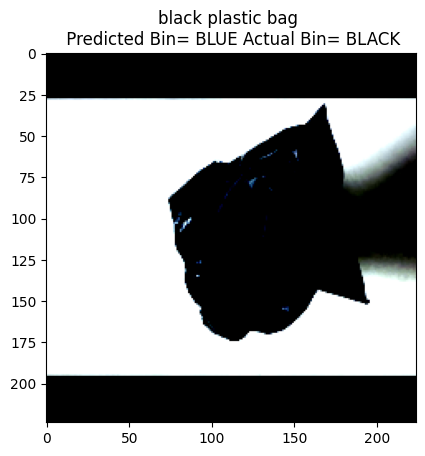

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


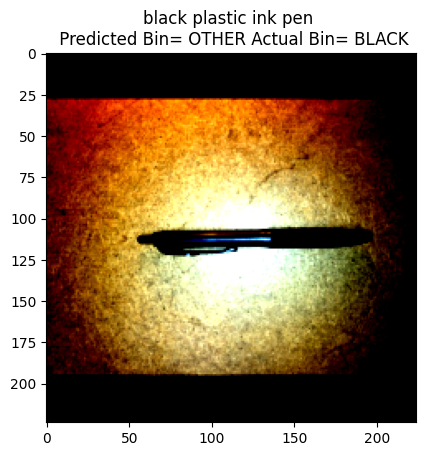

In [11]:
#PREDICTIONS
# Plot the misclassified samples
# label to word
def bin(label):
    if label == 0:
        color = 'BLACK'
    elif label == 1:
        color = 'BLUE'
    elif label == 2:
        color = 'GREEN'
    elif label == 3:
        color = 'OTHER'
    return color

def show_data(data_sample):
    plt.imshow(data_sample[0].transpose(1,2,0))
    label = bin(data_sample[1])
    predicted = bin(data_sample[2])
    plt.title(data_sample[3]+'\n Predicted Bin= '+ predicted + ' Actual Bin= ' + label)

# predicted = 0
# labels = 0
net.eval()
with torch.no_grad():
    counter = 0
    for batch in predloader:
        if counter > 5: #end after 5 pictures shown
            break
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        label = batch['label']
        images = batch['image']
        text = batch['text']
        z = net(images, input_ids, attention_mask)
        _, ypred = torch.max(z.data, 1)
        predicted = ypred.cpu().numpy()
        labels= label.cpu().numpy()
        image = images.numpy()

        for i in range(len(predicted)):
            if predicted[i] != labels[i]:
                plt.figure()
                show_data((image[i], labels[i], predicted[i], text[i]))
                plt.show()
                counter += 1
            if counter >5:
                break


# References

These were useful in writing the code, and implementing the model.

1.   CNN Minst, and garbage classification tutorials
2.   https://www.pluralsight.com/resources/blog/guides/introduction-to-resnet
3. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
4. Multimodal https://www.kaggle.com/code/fabraz/image-and-text-multimodal
5. https://wandb.ai/mostafaibrahim17/ml-articles/reports/The-Basics-of-ResNet50---Vmlldzo2NDkwNDE2#pytorch
6. Custom Data set looking at ImageFolder https://dilithjay.com/blog/custom-image-classifier-with-pytorch
7. Handling imbalanced data: https://saturncloud.io/blog/how-to-use-class-weights-with-focal-loss-in-pytorch-for-imbalanced-multiclass-classification/
8. Adam optimizer: https://www.datacamp.com/tutorial/adamw-optimizer-in-pytorch

